In [5]:
from geometry import *
import numpy as np
import pypower
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline

def make_power(X,w):
    A = np.array([[ 0, 0, 1],
                  [ 0, 0,-1],
                  [ 0, 1, 0],
                  [ 0,-1, 0],
                  [ 1, 0, 0],
                  [-1, 0, 0]])
    b = np.array([100,100,1,1,1,1])
    return pypower.power_diagram(X,w,A,b)

# X=(x,y,z) is above the graph of (x,y) -> sqrt(|(x,y)-p|^2 + beta**2) + b_i
# <=> z >= sqrt((x-px)^2 + (y-py)^2 + beta**2) + b_i
# <=> (z-b_i)^2 >= (x-px)^2 + (y-py)^2 + beta**2 (AND z>=b_i...)
# <=> <Q(X-R)|(X-R)> - beta**2 >= 0 and z-b_i>=0
# with Q = diag(-1,-1,1), R = (px,py,bi)
# <=> <QX|X> + 2<QR|X> + <QR|R> - beta**2 >= 0

def make_hyperboloid(p, bi, beta):
    Q = np.array([-1,-1,1])
    R = np.array([p[0],p[1],bi])
    return Quadric(Q,b=2*Q*R,c=np.dot(Q*R,R) - beta**2,
                   truncating_plane=True,p=np.array([0,0,1]),d=-bi)


def make_laguerre(Y, psi, beta, k=20):
    assert(all(psi > 0))
    N = len(Y)
    X = np.zeros((N,3))
    X[:,0:2] = Y
    X[:,2] = -psi
    #w = 2*(Y[:,0]**2 + Y[:,1]**2)
    w = 2*psi**2
    
    cells = make_power(X,w)
    curves = []
    for i in range(N):
        quad = make_hyperboloid(Y[i], psi[i], beta)
        c = intersect_cell_with_quadric(X,cells[i],quad,k)
        curves.append(c)
    return curves

def plot_laguerre(allcurves):
    areas = []
    for curves in allcurves:
        area = 0
        for j,curvesj in curves.items():
            for crv in curvesj:
                crv = np.array(crv)
                for i in range(crv.shape[0]-1):
                    a = crv[i,0:2]
                    b = crv[i+1,0:2]
                    area += np.linalg.det(np.array([a,b]))/2
                plt.plot(crv[:,0], crv[:,1], '.k')
        areas.append(area)
    return areas

def nabla_y_cost(x,y,beta):
    return (y-x)/ np.sqrt(np.linalg.norm(x-y)**2 + beta**2)

def compute_H_DH_from_laguerre(Y, beta, allcurves):
    areas = []
    N = len(allcurves)
    areas = np.zeros(N)
    DH = np.zeros((N,N))
    for i in range(N):
        curves = allcurves[i]
        for j,curvesj in curves.items():
            for crv in curvesj:
                crv = np.array(crv)
                for k in range(crv.shape[0]-1):
                    a = crv[k,0:2]
                    b = crv[k+1,0:2]
                    areas[i] += np.linalg.det(np.array([a,b]))/2
                    if j<0:
                        continue
                    length  = np.linalg.norm(b-a)
                    x = (a+b)/2
                    hij = length/np.linalg.norm(nabla_y_cost(x,Y[i],beta) - nabla_y_cost(x,Y[j],beta))
                    DH[i,j] += hij
                    DH[i,i] -= hij
    return np.array(areas), DH

[0.6580075642692866, 0.6122624779547533, 0.49448211043662127, 0.11509226928308255, 0.29011475366716954, 0.6416938104459554, 0.4551716098137869, 0.43240932723094705, 0.15191351593165406, 0.14890279930771588]
4.000050238340973
0.0004896101723437888


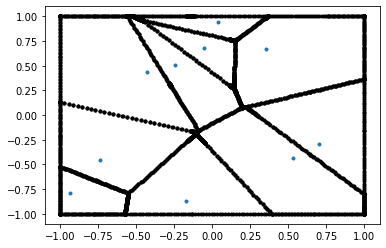

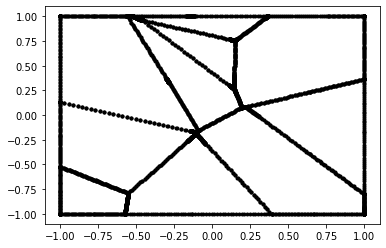

In [6]:
N = 10
Y = 2*(np.random.rand(N,2)-.5)
psi = 0.001*np.random.rand(N)
beta = 1
curves = make_laguerre(Y, psi, beta,k=30)

plt.figure()
areas = plot_laguerre(curves)
plt.plot(Y[:,0],Y[:,1],'.')
print(areas)
print(np.sum(areas))


psi += 0.2
curves = make_laguerre(Y, psi, beta, k=30)
plt.figure()
areas2 = plot_laguerre(curves)
print(np.linalg.norm(np.array(areas)-np.array(areas2))/N)

In [32]:
def check_gradient(f,gradf,x0):
    N = len(x0)
    gg = np.zeros((N,N))
    for i in range(N):
        eps = 1e-3
        e = np.zeros(N)
        e[i] = eps
        gg[i,:] = (f(x0+e) - f(x0-e))/(2*eps)
    print('erreur numérique dans le calcul du gradient: %g (doit être petit)' % np.linalg.norm(gradf(x0)-gg))
    print(gradf(x0))
    print(gg)
    
N = 5
Y = 2*(np.random.rand(N,2)-.5)
beta = 1

H = lambda psi: compute_H_DH_from_laguerre(Y,beta,make_laguerre(Y, psi, beta, k=100))[0]
DH = lambda psi: compute_H_DH_from_laguerre(Y,beta,make_laguerre(Y, psi, beta, k=100))[1]

psi = 0.11*np.ones(N)
np.set_printoptions(2)
check_gradient(H,DH,psi)

erreur numérique dans le calcul du gradient: 2.88354 (doit être petit)
[[-2.17e+00  5.84e-01  7.96e-04  1.05e+00  5.35e-01]
 [ 5.84e-01 -8.15e+00  3.99e-02  7.52e+00  0.00e+00]
 [ 7.96e-04  3.99e-02 -4.07e-02  0.00e+00  0.00e+00]
 [ 1.05e+00  7.52e+00  0.00e+00 -9.24e+00  6.66e-01]
 [ 5.35e-01  0.00e+00  0.00e+00  6.66e-01 -1.20e+00]]
[[-2.24e+00  5.07e-01  7.66e-04  9.61e-01  7.75e-01]
 [ 5.05e-01 -6.69e+00  2.79e-02  6.16e+00  2.50e-13]
 [ 2.34e-03  2.97e-02 -3.20e-02 -4.66e-12  2.50e-13]
 [ 9.61e-01  6.16e+00  0.00e+00 -7.73e+00  6.14e-01]
 [ 7.75e-01  1.72e-12  0.00e+00  6.14e-01 -1.39e+00]]


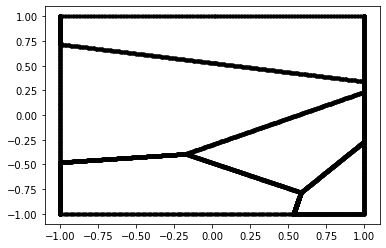

0 -> 
H(psi) =  [0.2  1.51 0.57 0.77 0.94]
psi =  [0.11 0.11 0.11 0.11 0.11]


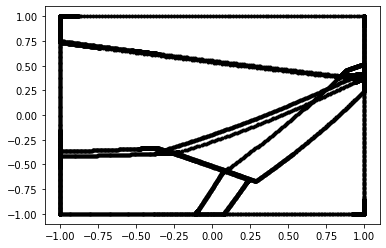

[[-3.31  0.    2.39  0.82  0.1 ]
 [ 0.   -6.89  2.92  1.24  2.72]
 [ 1.78  2.97 -6.73  1.89  0.09]
 [ 0.59  1.05  1.95 -3.59  0.  ]
 [ 0.    2.53  0.16  0.   -2.69]]
t=0.5
1 -> 
H(psi) =  [0.95 1.42 0.49 0.69 0.89]
psi =  [0.11 0.47 0.36 0.37 0.49]
len(S)<1: []
quad(a): 0.08644084434142263


ValueError: zero-size array to reduction operation minimum which has no identity

In [24]:
N = 5
psi = 0.11*np.ones(N)
Y = 2*(np.random.rand(N,2)-.5)
beta = 1

def H_DH(psi):
    lag = make_laguerre(Y, psi, beta, k=100)
    plt.figure()
    plot_laguerre(lag)
    plt.show()
    return compute_H_DH_from_laguerre(Y,beta,lag)

h,dh = H_DH(psi)
for i in range(5):
    print("%d -> " % i) 
    print("H(psi) = ", h)
    print("psi = ", psi)
    dh = dh[0:N-1,0:N-1]
    h = h[0:N-1]
    d = np.zeros(N)
    d[0:N-1] = -np.linalg.solve(dh, h - 4/N)
    t = .5
    d = d - min(d)
    psi0 = psi.copy()
    while True:
        psi = psi0 + t*d
        h,dh = H_DH(psi)
        if min(h) > 0:
            print(dh)
            print("t=%g"%t)
            break
        t = t/2
 

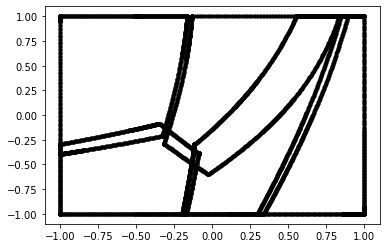

4.669010413639347

In [13]:
lag = make_laguerre(Y, psi, beta, k=100)
plt.figure()
plot_laguerre(lag)
plt.show()
np.sum(H(psi))

In [ ]:
# gradient descent

psi = 1*np.ones(N)
for i in range(10):
    h,dh = H_DH(psi)
    print("H(psi) = ", h)
    psi = psi + 0.1*(h-4/N)

In [ ]:
def area_of_cell(curves):
    if curves is None:
        return 0.0
    area = 0.0
    # compute area of cell i by integrating over the boundary
    # j is the number of the adjacent cell (negative number if adjacency 
    # is with the boundary)
    for j,curvesj in curves.items():
        for crv in curvesj:
            crv = np.array(crv)
            for k in range(crv.shape[0]-1):
                a = crv[k,0:2]
                b = crv[k+1,0:2]
                area += np.linalg.det(np.array([a,b]))/2
    return area

def areas_of_power_diagram_quadric_intersection(X,w,quad):
    cells = pypower.power_diagram(X,w)
    areas = [area_of_cell(intersect_cell_with_quadric(X,c,quad,20)) for c in cells]
    return np.array(areas)
 
N = 10
quad = Quadric(np.diag([-1,-1,0]), np.array([0,0,1]), 1)
X = np.random.rand(N,3)
w = np.zeros(N)
H = lambda w: areas_of_power_diagram_quadric_intersection(X,w,quad)
H(w)

In [ ]:

def enlarge(x):
    z = np.zeros(len(x)+1)
    z[1:] = x
    return z
x = opt.fsolve(lambda x: (H(enlarge(x)) - 4/N)[1:], np.zeros(N-1))
w = enlarge(x)

In [ ]:
# Oliker-Prussner
N = 10
X = np.random.rand(N,3)
w = np.zeros(N)
w[0] = 5
delta = 0.35
nu = 4*np.ones(N)/N

def H(w):
    return areas_of_power_diagram_quadric_intersection(X,w,quad)
def Hi(w,i):
    cells = pypower.power_diagram(X,w)
    return area_of_cell(intersect_cell_with_quadric(X,cells[i],quad,20))
def e(i):
    x = np.zeros(N)
    x[i] = 1
    return x
    
while delta>0.01:
    print("delta={}".format(delta))
    good = False
    while not good:
        good = True
        t = np.zeros(N)
        for i in range(1,N):
            if Hi(w,i) >= nu[i] - delta:
                continue
            f = lambda s: Hi(w+s*e(i),i) - nu[i]
            # cell i does not have enough mass: we need to increase w
            t[i] = opt.root_scalar(f, bracket=[0,10]).root
            good = False
        print(np.linalg.norm(H(w) - 4/N))
        w = w + t
    delta /= 2

In [ ]:
# check (visually) the computation of the intersection between a triangle and a quadric

def trisample(A, B, C,N):
    r1 = np.random.rand(N)
    r2 = np.random.rand(N)
    s1 = np.sqrt(r1)

    X = np.zeros((N,3))
    X[:,0] = A[0] * (1.0 - s1) + B[0] * (1.0 - r2) * s1 + C[0] * r2 * s1
    X[:,1] = A[1] * (1.0 - s1) + B[1] * (1.0 - r2) * s1 + C[1] * r2 * s1
    X[:,2] = A[2] * (1.0 - s1) + B[2] * (1.0 - r2) * s1 + C[2] * r2 * s1
    return X


def test_triangle():
    above = np.array([0,0,2])
    quad = make_quad(np.array([0,0]),0,1)
    v = np.random.rand(3)
    w = np.random.rand(3)
    
    X = trisample(above,v,w,1000)
    s = np.array([quad(x) for x in X]).flatten()
    plt.plot(X[s>0,0], X[s>0,1],'.r')
    plt.plot(X[s<0,0], X[s<0,1],'.b')

    curves = intersect_triangle_with_quadric(quad, v, w, above)
    for c in curves:
        plt.plot(c[:,0], c[:,1],'g', linewidth=4)
        
#test_triangle()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

quad = make_quad(np.array([0,0]),0,.1)

N= 5
X = np.random.rand(N,3)
w = np.zeros(N)
cells = make_power(X,w)

area = 0
plt.figure(figsize=(10,10))
for i in range(N):
    curves = intersect_cell_with_quadric(X,cells[i],quad,30)
    if curves is None:
        print("empty cell {}".format(i))
        continue
    for j,curvesj in curves.items():
        for crv in curvesj:
            crv = np.array(crv)
            for i in range(crv.shape[0]-1):
                a = crv[i,0:2]
                b = crv[i+1,0:2]
                area += np.linalg.det(np.array([a,b]))/2
            plt.plot(crv[:,0], crv[:,1], 'k')
print(area)